## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

images count 20


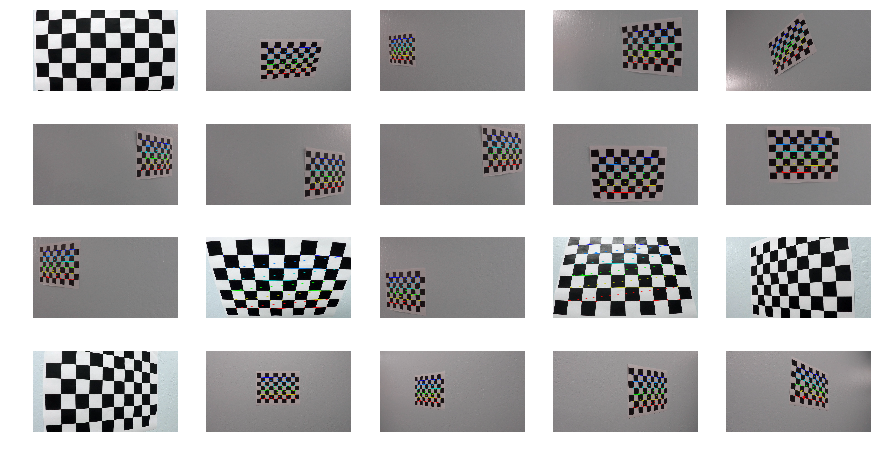

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

images_count = len(images)
print('images count {}'.format(images_count))

# Step through the list and search for chessboard corners
fig, axs = plt.subplots(images_count/5,5, figsize=(15,8))
axs = axs.ravel()
i = 0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    axs[i].axis('off')
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    axs[i].imshow(img)
    i += 1

cv2.destroyAllWindows()

so there are 3 images can not find corner

## And then undistort the images

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function.applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

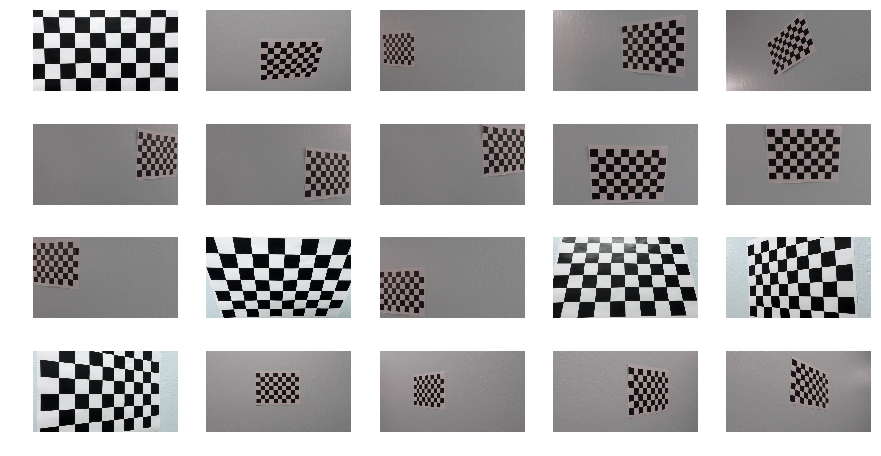

In [2]:
calibration_shape = gray.shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, calibration_shape, None, None)

# Step through the list and search for chessboard corners
fig, axs = plt.subplots(images_count/5,5, figsize=(15,8))
axs = axs.ravel()
i = 0
for fname in images:
    img = cv2.imread(fname)
    img_undistort = cv2.undistort(img, mtx, dist, None, mtx)
    axs[i].axis('off')
    axs[i].imshow(img_undistort)
    i += 1
cv2.destroyAllWindows()

# Pipeline (single images)

### 1. Provide an example of a distortion-corrected image

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:
![alt text](./test_images/test1.jpg)

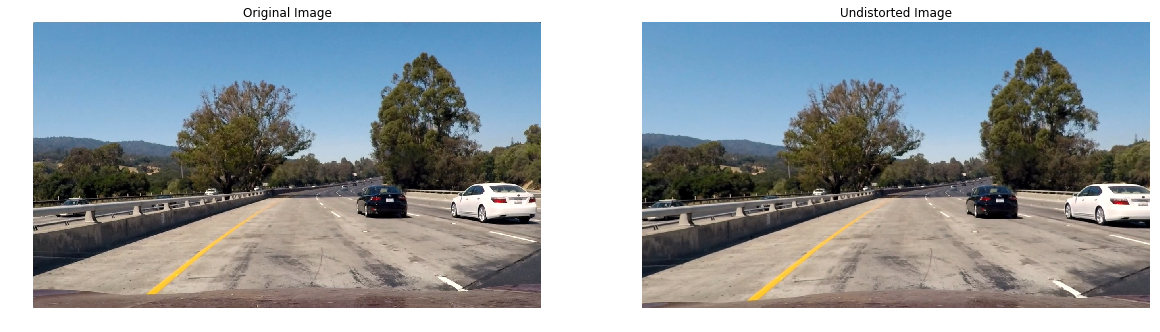

In [3]:
img_original = cv2.imread("./test_images/test1.jpg")
img_undistort = cv2.undistort(img_original, mtx, dist, None, mtx)

fig, axs = plt.subplots(1,2, figsize=(20,6))
axs = axs.ravel()
axs[0].axis("off")
axs[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[1].axis("off")
axs[1].imshow(cv2.cvtColor(img_undistort, cv2.COLOR_BGR2RGB))
axs[1].set_title("Undistorted Image")

# 2.used color transforms, gradients or other methods to create a thresholded binary image

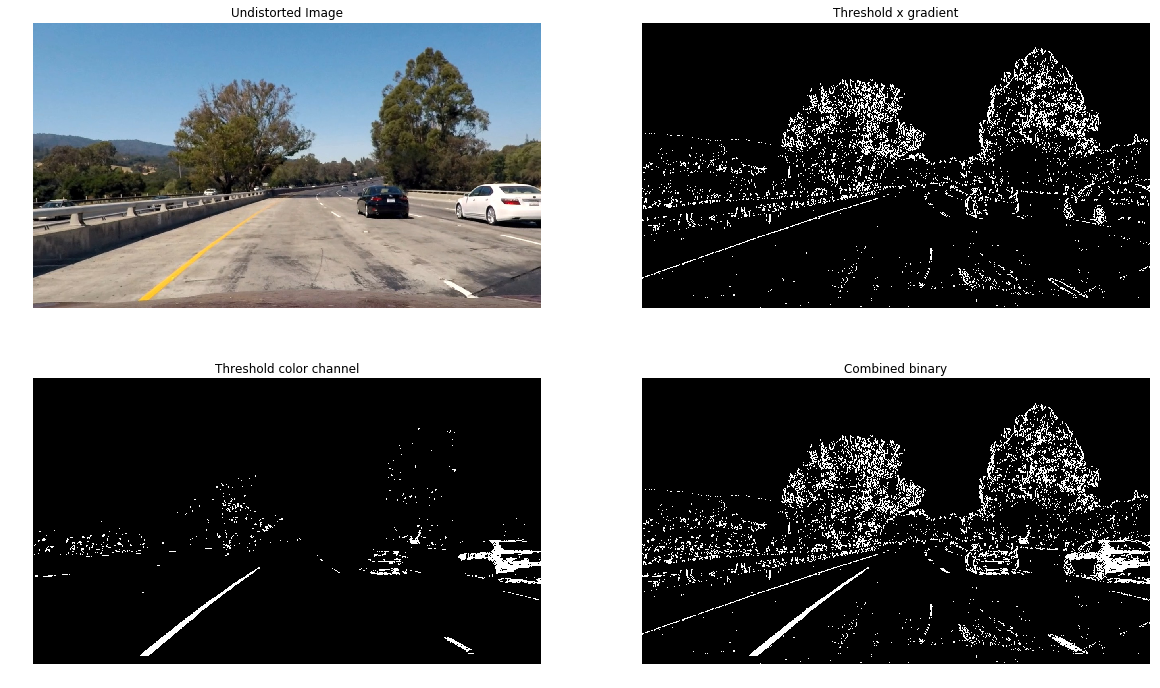

In [4]:
import cv2
import numpy as np

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

img = np.copy(img_undistort)
# Convert to HSV color space and separate the V channel
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hsv[:, :, 1]
s_channel = hsv[:, :, 2]
# Sobel x
sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

# Threshold x gradient
sx_thresh=(20, 100)
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

# Threshold color channel
s_thresh=(170, 255)
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
# Stack each channel
# Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
# be beneficial to replace this channel with something else.
color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))

combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

fig, axs = plt.subplots(2,2, figsize=(20,12))
axs = axs.ravel()
axs[0].axis("off")
axs[0].imshow(cv2.cvtColor(img_undistort, cv2.COLOR_BGR2RGB))
axs[0].set_title("Undistorted Image")
axs[1].axis("off")
axs[1].imshow(sxbinary, cmap='gray')
axs[1].set_title("Threshold x gradient")
axs[2].axis("off")
axs[2].imshow(s_binary, cmap='gray')
axs[2].set_title("Threshold color channel")
axs[3].axis("off")
axs[3].imshow(combined_binary, cmap='gray')
axs[3].set_title("Combined binary")

# 3. Performed a perspective transform and provide an example of a transformed image.

The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.


[[  585.   460.]
 [  203.   720.]
 [ 1126.   720.]
 [  695.   460.]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


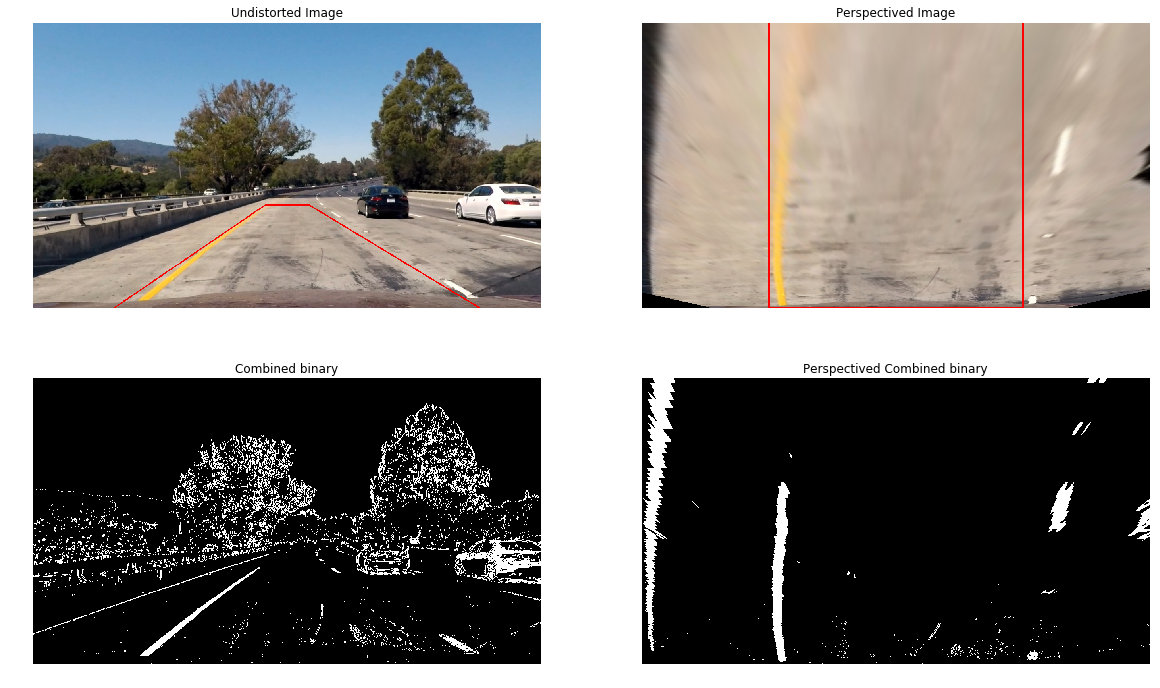

In [5]:
img = np.copy(img_undistort)
binary_warped = np.copy(combined_binary)
# performed a perspective transform
img_size = img.shape[1], img.shape[0]
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
print(src)
print(dst)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
perspective_image = cv2.warpPerspective(img, M, dsize=img_size, flags=cv2.INTER_LINEAR)
perspective_image_copy = np.copy(perspective_image)
perspective_binary_warped = cv2.warpPerspective(binary_warped, M, dsize=img_size, flags=cv2.INTER_LINEAR)

cv2.line(img,(src[0][0],src[0][1]),(src[1][0],src[1][1]),(0,0,255),2)
cv2.line(img,(src[1][0],src[1][1]),(src[2][0],src[2][1]),(0,0,255),2)
cv2.line(img,(src[2][0],src[2][1]),(src[3][0],src[3][1]),(0,0,255),2)
cv2.line(img,(src[3][0],src[3][1]),(src[0][0],src[0][1]),(0,0,255),2)
cv2.line(perspective_image_copy,(dst[0][0],dst[0][1]),(dst[1][0],dst[1][1]),(0,0,255),4)
cv2.line(perspective_image_copy,(dst[1][0],dst[1][1]),(dst[2][0],dst[2][1]),(0,0,255),4)
cv2.line(perspective_image_copy,(dst[2][0],dst[2][1]),(dst[3][0],dst[3][1]),(0,0,255),4)
cv2.line(perspective_image_copy,(dst[3][0],dst[3][1]),(dst[0][0],dst[0][1]),(0,0,255),4)

fig, axs = plt.subplots(2,2, figsize=(20,12))
axs = axs.ravel()
axs[0].axis("off")
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Undistorted Image")
axs[1].axis("off")
axs[1].imshow(cv2.cvtColor(perspective_image_copy, cv2.COLOR_BGR2RGB))
axs[1].set_title("Perspectived Image")
axs[2].axis("off")
axs[2].imshow(binary_warped, cmap='gray')
axs[2].set_title("Combined binary")
axs[3].axis("off")
axs[3].imshow(perspective_binary_warped, cmap='gray')
axs[3].set_title("Perspectived Combined binary")


 # 4.identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

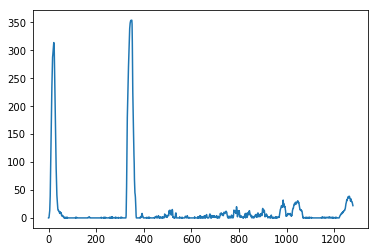

In [6]:
import numpy as np
histogram = np.sum(perspective_binary_warped[perspective_binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

so i set leftpoint with 1/8 and rightpoint with 7/8

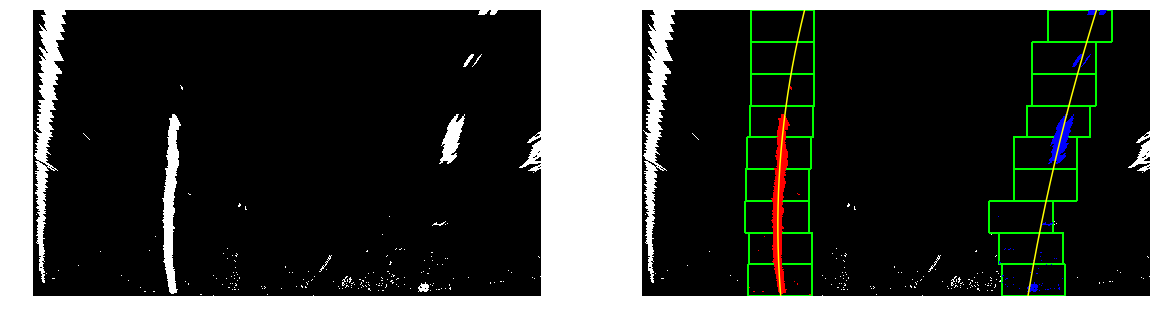

In [7]:
binary_warped = perspective_binary_warped
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):, :], axis=0)
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
leftpoint = np.int(histogram.shape[0] / 8)
midpoint = np.int(histogram.shape[0] / 2)
rightpoint = np.int(histogram.shape[0] * 7 / 8)
leftx_base = np.argmax(histogram[leftpoint:midpoint]) + leftpoint
rightx_base = np.argmax(histogram[midpoint:rightpoint]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0] / nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window + 1) * window_height
    win_y_high = binary_warped.shape[0] - window * window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 4)
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 4)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
    nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
    nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

fig, axs = plt.subplots(1,2, figsize=(20,6))
axs = axs.ravel()
axs[0].axis("off")
axs[0].imshow(binary_warped, cmap='gray')
axs[1].axis("off")
axs[1].imshow(out_img)
axs[1].plot(left_fitx, ploty, color='yellow')
axs[1].plot(right_fitx, ploty, color='yellow')

# 5.calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [9]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30.0/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
curverad = min(left_curverad, right_curverad)
print("left:{:.2f}m\trighr:{:.2f}m\tmin:{:.2f}m".format(left_curverad, right_curverad, curverad))

left:719.32m	righr:1634.51m	min:719.32m


In [10]:
# Caculate the distance of center
midpoint = np.int(binary_warped.shape[1] / 2)
image_height = binary_warped.shape[0]
leftpoint = left_fit[0]*image_height*image_height + left_fit[1]*image_height + left_fit[2]
rightpoint = right_fit[0]*image_height*image_height + right_fit[1]*image_height + right_fit[2]
diffpoint = (leftpoint+rightpoint)/2 - midpoint
print("leftpoint: {}  rightpoint: {} diffpoint {}".format(leftpoint, rightpoint, diffpoint))
diffditance = diffpoint * xm_per_pix
print("left of center {:.2f}m".format(diffditance))

leftpoint: 349.413038023  rightpoint: 973.334230631 diffpoint 21.373634327
left of center 0.11m


# 6.Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

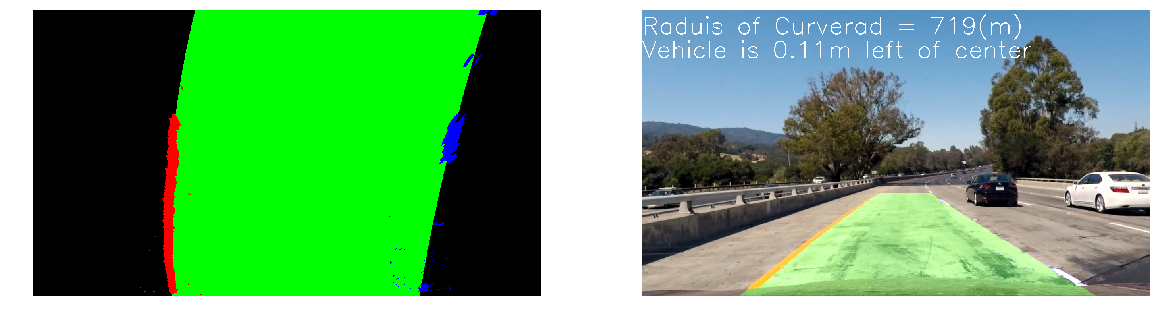

In [21]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 0, 255]
color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size)
# Combine the result with the original image
result = cv2.addWeighted(img_undistort, 1, newwarp, 0.3, 0)
text1 = "Raduis of Curverad = {:.0f}(m)".format(curverad)
cv2.putText(result, text1, (0,60),cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2)
text2 = "Vehicle is {:.2f}m left of center".format(diffditance)
cv2.putText(result, text2, (0,120),cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2)

fig, axs = plt.subplots(1,2, figsize=(20,6))
axs = axs.ravel()
axs[0].axis("off")
axs[0].imshow(cv2.cvtColor(color_warp, cv2.COLOR_BGR2RGB))
axs[1].axis("off")
axs[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))